In [2]:
from pandas import Series, DataFrame
import pandas as pd
import nltk
import operator
import re,string
from patsy import dmatrices
%pylab inline
from nltk.corpus import stopwords
import re
from itertools import chain
from collections import Counter
import random
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

Populating the interactive namespace from numpy and matplotlib


/Users/tiffanysung/anaconda2/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Part A

### A1

In [3]:
train_data = pd.read_csv('Train_rev1.csv')

In [4]:
train_data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In order to find the top 5 POS, we need to first tokenize the full description.<br> 
We'll do this by first taking a random sample size of 5000.

In [5]:
random.seed(99)
sample_2500 = random.sample(range(len(train_data)),2500)
sample_data = train_data['FullDescription'][sample_2500]
sample_data[:3]

105900    Passionate about making lives better, Bupa is ...
99812     Category Manager  Milton Keynes High profile r...
52448     The Company: Our client enjoys a high profile ...
Name: FullDescription, dtype: object

Then we conduct nltk tokenize to our sample. But there's still some steps before tokenize.

In [9]:
full_des = sample_data.sum().lower()
des_words = nltk.word_tokenize(full_des)
des_words = [word for word in des_words if word.isalpha()==True] #get rid of punctuation

In [10]:
pos = nltk.pos_tag(des_words)
pos[:10]

[('passionate', 'NN'),
 ('about', 'IN'),
 ('making', 'VBG'),
 ('lives', 'NNS'),
 ('better', 'JJR'),
 ('bupa', 'NN'),
 ('is', 'VBZ'),
 ('dedicated', 'VBN'),
 ('to', 'TO'),
 ('clinical', 'JJ')]

Then, get the top 5 POS.

In [11]:
cnt = Counter(tag for word,tag in pos)
cnt.most_common()[:5]

[('NN', 152724), ('JJ', 68586), ('IN', 65605), ('DT', 50872), ('NNS', 50168)]

Looks like 'NN': Singular Noun, 'JJ': Adjective, 'IN': Preposition or subordinating conjunction, 'NNS': Pural Noun and 'DT': Determiner are the 5 most common POS in the description.<br>
<br>
Let's do the process again and this time, exclude the stopwords.

In [13]:
filtered_stopwords = [word for word in des_words if word not in stopwords.words('english')]
filtered_pos = nltk.pos_tag(filtered_stopwords)
cnt2 = Counter(tag for word,tag in filtered_pos)
cnt2.most_common()[:5]

[('NN', 147557), ('JJ', 71278), ('NNS', 49725), ('VBG', 25335), ('VBP', 16835)]

After excluding the stopwords, Singular Noun, Adjective and Pural Noun are still in the top 5 list. Verb(gerund or present participle) and Verb(non-3rd person singular present) are added in the top 5 POS.

### A2

First, calculate the frequency of words and sort them.

In [14]:
#Calculate frequency.
fdist = nltk.FreqDist(des_words)

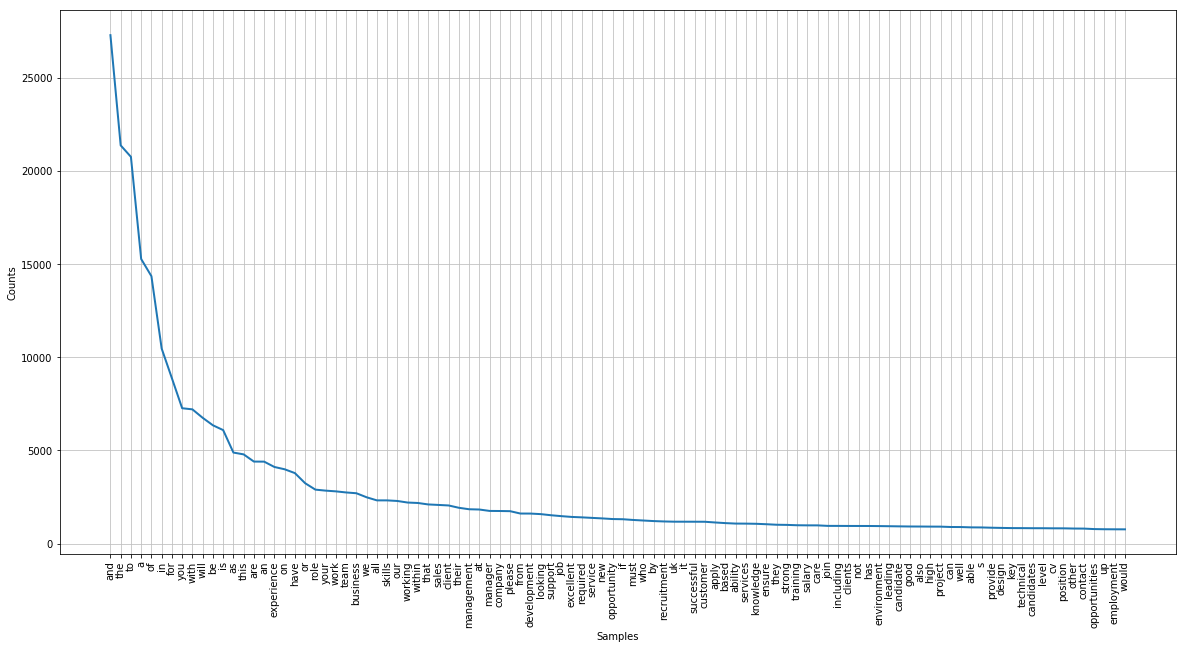

In [15]:
#Plot the top 100 against Zipf's Law
plt.figure(figsize=(20,10))
fdist.plot(100, cumulative=False)

In [16]:
#Sorted by frequency
sort_fdist = pd.DataFrame(sorted(fdist.items(), key=operator.itemgetter(1),reverse=True))
most_common_100 = sort_fdist[:100]
most_common_100.columns = ['word','frequency']
most_common_100['rank'] = most_common_100['frequency'].rank(method='min',ascending=False)
most_common_100['zipf_law'] = [most_common_100["frequency"].max()/r for r in most_common_100['rank']]
most_common_100[:10]

/Users/tiffanysung/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/tiffanysung/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,word,frequency,rank,zipf_law
0,and,27305,1.0,27305.000000
1,the,21386,2.0,13652.500000
2,to,20769,3.0,9101.666667
3,a,15282,4.0,6826.250000
4,of,14359,5.0,5461.000000
5,in,10472,6.0,4550.833333
6,for,8876,7.0,3900.714286
7,you,7267,8.0,3413.125000
8,with,7206,9.0,3033.888889
9,will,6753,10.0,2730.500000


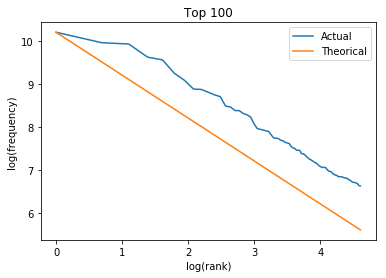

In [25]:
fig = plt.figure()

x = [math.log(c) for c in most_common_100['rank'].values]
y1 = [math.log(c) for c in most_common_100['frequency']]
y2 = [math.log(c) for c in most_common_100['zipf_law']]

ax1 = plt.plot(x,y1,label='Actual')
ax2 = plt.plot(x,y2,label='Theorical')

xlabel("log(rank)")
ylabel("log(frequency)")
title('Top 100')
plt.legend()
plt.show()

The above results show that the top 100 most does follow the Zipf's law in generally.<br>
Now, let's test the Zipf's law with the entire sample (2500 data points).

In [23]:
sort_fdist.columns = ['word','frequency']
sort_fdist['rank'] = sort_fdist['frequency'].rank(method='min',ascending=False)
sort_fdist['zipf_law'] = [sort_fdist["frequency"].max()/r for r in sort_fdist['rank']]

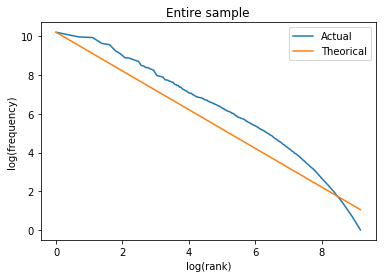

In [24]:
fig = plt.figure()

x = [math.log(c) for c in sort_fdist['rank'].values]
y1 = [math.log(c) for c in sort_fdist['frequency']]
y2 = [math.log(c) for c in sort_fdist['zipf_law']]

ax1 = plt.plot(x,y1,label='Actual')
ax2 = plt.plot(x,y2,label='Theorical')

xlabel("log(rank)")
ylabel("log(frequency)")
title('Entire sample')
plt.legend()
plt.show()

### A3

In [18]:
from nltk.corpus import wordnet
#create a function that would return WORDNET POS compliance to WORDENT lemmatization (a,n,r,v) 
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
         return wordnet.ADV
    else:
        # As default pos in lemmatization is Noun
        return wordnet.NOUN

In [19]:
wnl = WordNetLemmatizer()
#create an empty list to store lemmatized words
des_lem = []

In [20]:
def wn_pos(filtered_pos):
    for word,pos in filtered_pos:
        des_lem.append(wnl.lemmatize(word,get_wordnet_pos(pos)))
        #print pos
        #print get_wordnet_pos(pos)
    return des_lem

In [21]:
# Get the 10 most common words
fdist_2 = nltk.FreqDist(wn_pos(filtered_pos))
fdist_2.most_common(10)

[('work', 5197),
 ('experience', 4553),
 ('role', 3063),
 ('team', 3051),
 ('client', 2989),
 ('business', 2817),
 ('service', 2501),
 ('skill', 2288),
 ('within', 2178),
 ('sale', 2097)]

The top 10 most common words that appears in the job descriptions are shown above.